# Reconstruction of volume from simulated data

In [38]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.emfiles import crop_fourier_images, crop_fourier_volume
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

plt.rcParams["figure.figsize"]=8,8

### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

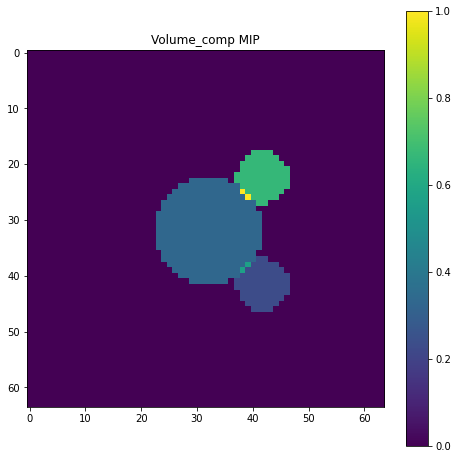

In [40]:
nx = 64
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [3, 3, 0], [3, -3, 0]])
radii = np.array([3, 1.5, 1.5])
intensities = np.array([10,7,20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid = volume_fourier(jnp.fft.ifftshift(vol), pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

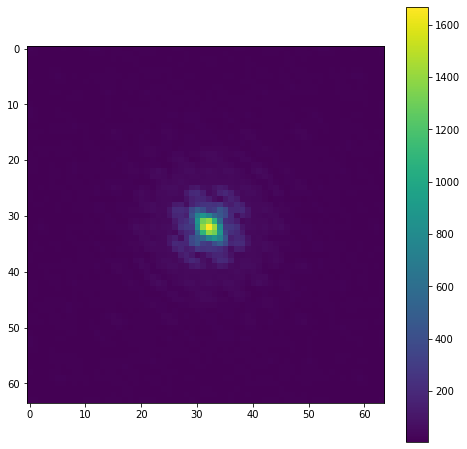

In [41]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

### Generate the data

CTF

In [42]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

#ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE], 
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC], 
#              'cs'    : p[star.Relion.CS], 
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array([p[star.Relion.DEFOCUSU],
                      p[star.Relion.DEFOCUSV],
                      p[star.Relion.DEFOCUSANGLE], 
                      p[star.Relion.PHASESHIFT],
                      p[star.Relion.VOLTAGE],
                      p[star.Relion.AC],
                      p[star.Relion.CS],
                      0,
                      2 * pixel_size])

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


Generate projections (in Fourier domain)

1.2870473861694336


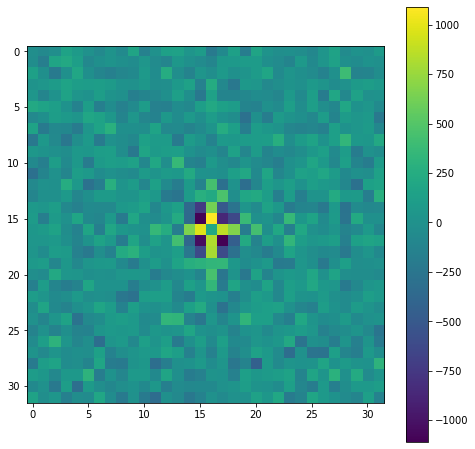

In [104]:
radius = 10
mask = create_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array = get_slice_funcs(project, x_grid, y_grid, z_grid, mask, "tri")

img0 = slice_func(vol_fourier, [0,0,0], [0,0], ctf_params0)

N = 1000

# Non uniformly distributed orientations (here, two clusters)
s = 0.2
#angles_true = jnp.array(np.random.rand(N,3))*jnp.pi*2
angles_true = s*np.random.randn(int(N),3)
angles_true = np.concatenate([s*np.random.randn(int(N/2),3), s*np.random.randn(int(N/2),3)+np.pi], axis=0)
np.random.shuffle(angles_true)
angles_true = jnp.array(angles_true)


shifts_true = jnp.zeros([N,3])
ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)

# Noise
imgs += (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * jnp.max(img0) *0.1

print(time.time()-start)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

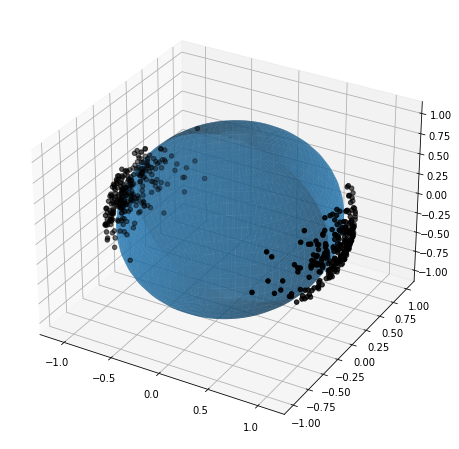

In [105]:
plot_angles(angles_true[:500])

### Crop images and volume:

In [106]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32
imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
imgs = imgs.reshape(imgs.shape[0], nx*nx)

vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

y_grid = x_grid
z_grid = x_grid

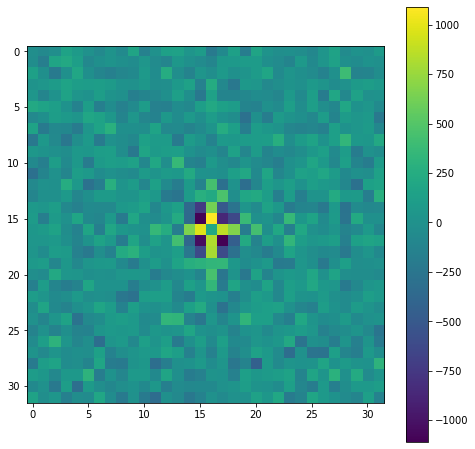

In [107]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

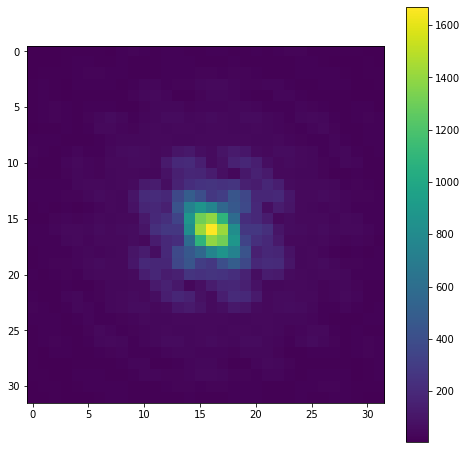

In [108]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

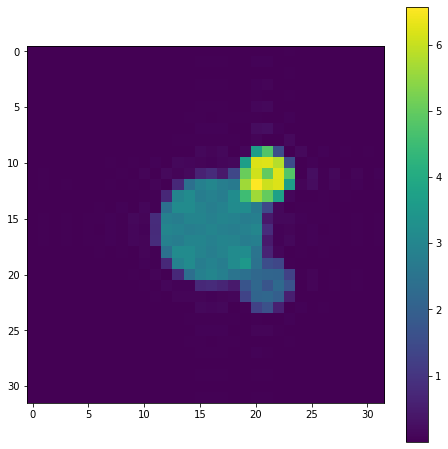

In [109]:
mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()

### Loss functions for the new dimension

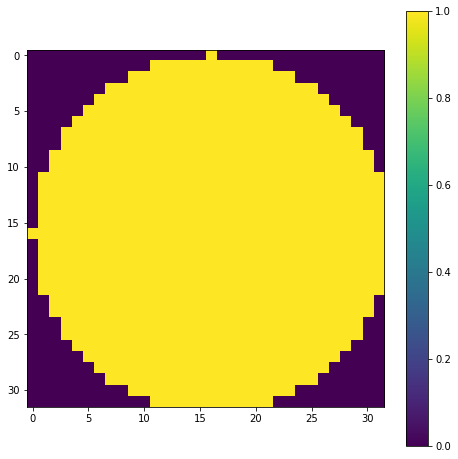

In [110]:
alpha = 0.001

radius = 0.8
mask = create_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array = get_slice_funcs(project, x_grid, y_grid, z_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [111]:
start = time.time()
ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time()-start)
print(ll.shape)

1.1804301738739014
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [112]:
start = time.time()
ll = grad_loss_volume(np.random.randn(nx,nx,nx), angles_true[0],  shifts_true[0], ctf_params[0], imgs[0])
print(time.time()-start)
print(ll.shape)

1.2156355381011963
(32, 32, 32)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [113]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(np.random.randn(nx,nx,nx), angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

1.3629603385925293
(32, 32, 32)


## Optimization with respect to volume

### CG - applied to two halves of the data

In [114]:
from src.algorithm import conjugate_gradient, get_cg_vol_ops

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 50

N2 = jnp.floor(N/2).astype(jnp.int64)
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N2], shifts_true[:N2], ctf_params[:N2], imgs[:N2], v0.shape)

vcg1,_ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

Iter 0 ||r|| = 0.4715657831174384
Iter 1 ||r|| = 0.2223837157401459
Iter 2 ||r|| = 0.1529192013648152
Iter 3 ||r|| = 0.13088289998960204
Iter 4 ||r|| = 0.10554942365403588
Iter 5 ||r|| = 0.07459437439322072
Iter 6 ||r|| = 0.06456262021131615
Iter 7 ||r|| = 0.06328685557597373
Iter 8 ||r|| = 0.04852754446364695
Iter 9 ||r|| = 0.04476570751852254
Iter 10 ||r|| = 0.03766741050264379
Iter 11 ||r|| = 0.03197077532754134
Iter 12 ||r|| = 0.028426118363611558
Iter 13 ||r|| = 0.025472507598486637
Iter 14 ||r|| = 0.021812691945418582
Iter 15 ||r|| = 0.02186339778369496
Iter 16 ||r|| = 0.019244192487769846
Iter 17 ||r|| = 0.017523661806964408
Iter 18 ||r|| = 0.016019276131781644
Iter 19 ||r|| = 0.015495658860778545
Iter 20 ||r|| = 0.01541350502357733
Iter 21 ||r|| = 0.01290065608663775
Iter 22 ||r|| = 0.012395602473577239
Iter 23 ||r|| = 0.010463861465160451
Iter 24 ||r|| = 0.009963022157321892
Iter 25 ||r|| = 0.00888008263569025
Iter 26 ||r|| = 0.0085742678186664
Iter 27 ||r|| = 0.00731972020033

In [115]:
AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:], v0.shape)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, verbose = True)

Iter 0 ||r|| = 0.47821937515134944
Iter 1 ||r|| = 0.2257121369214452
Iter 2 ||r|| = 0.15604501968949228
Iter 3 ||r|| = 0.1302729079521224
Iter 4 ||r|| = 0.10558186684109996
Iter 5 ||r|| = 0.07496682816239732
Iter 6 ||r|| = 0.06447575926583726
Iter 7 ||r|| = 0.06404072862954052
Iter 8 ||r|| = 0.049764745678588684
Iter 9 ||r|| = 0.04593275733437436
Iter 10 ||r|| = 0.03757914597572224
Iter 11 ||r|| = 0.03169192581110521
Iter 12 ||r|| = 0.028350825784618026
Iter 13 ||r|| = 0.024180467970258912
Iter 14 ||r|| = 0.021161707299709467
Iter 15 ||r|| = 0.022001854418585428
Iter 16 ||r|| = 0.020788290188579927
Iter 17 ||r|| = 0.018561105198648568
Iter 18 ||r|| = 0.01644282936169831
Iter 19 ||r|| = 0.01519353043797058
Iter 20 ||r|| = 0.015055835293449438
Iter 21 ||r|| = 0.013124253358075622
Iter 22 ||r|| = 0.012094452934736481
Iter 23 ||r|| = 0.010499262556895561
Iter 24 ||r|| = 0.009063611021011319
Iter 25 ||r|| = 0.008231817197443349
Iter 26 ||r|| = 0.008076782503297842
Iter 27 ||r|| = 0.00641075

In [116]:
#print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

Relative error =  0.7650533957038399
Absolute error =  33.70584851443018


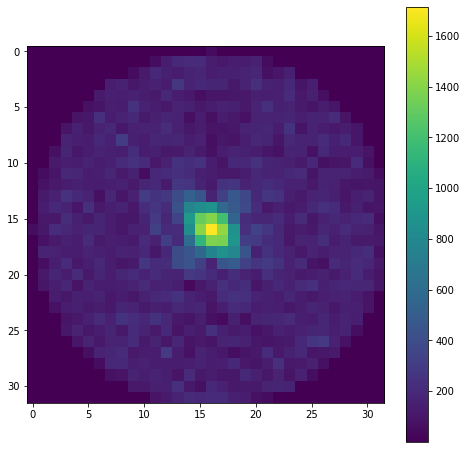

In [117]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ; plt.colorbar()

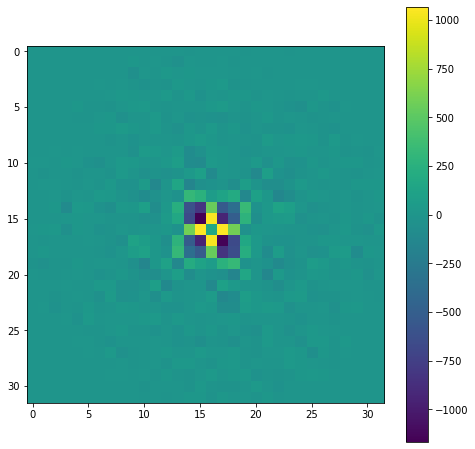

In [118]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

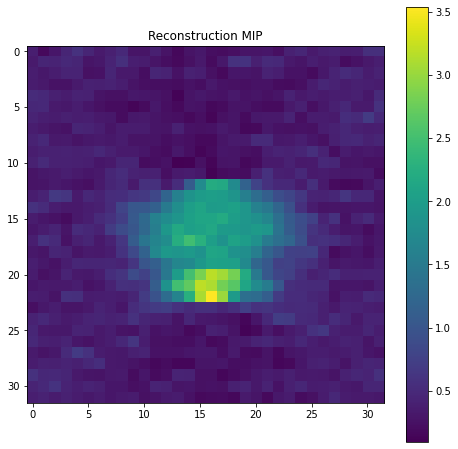

In [119]:
mip_x(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

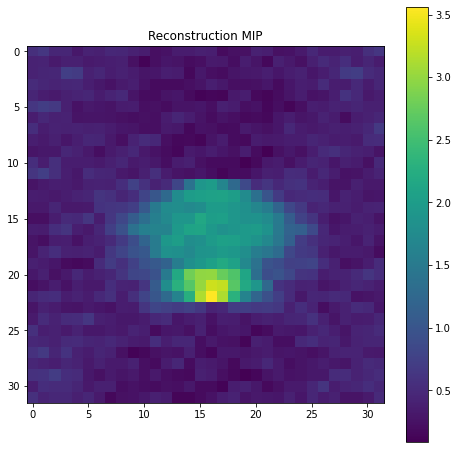

In [120]:
mip_x(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

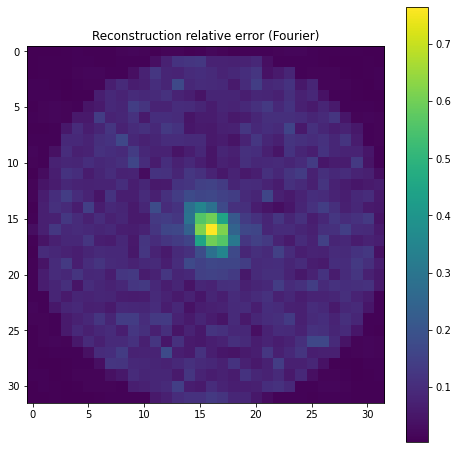

In [121]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

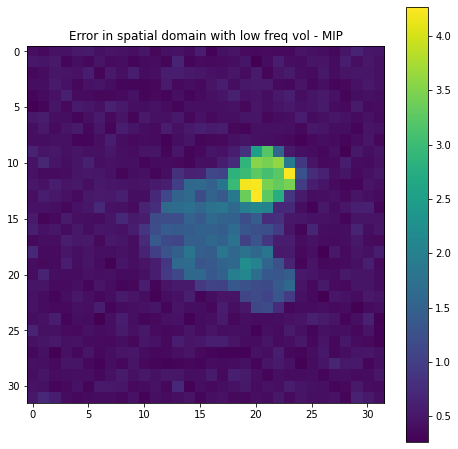

In [122]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

### FSC

In [123]:
res, fsc = calc_fsc(vcg1, vcg2, x_grid, dr = 0.05)

Text(0.5, 1.0, 'Clustered angles - mixed')

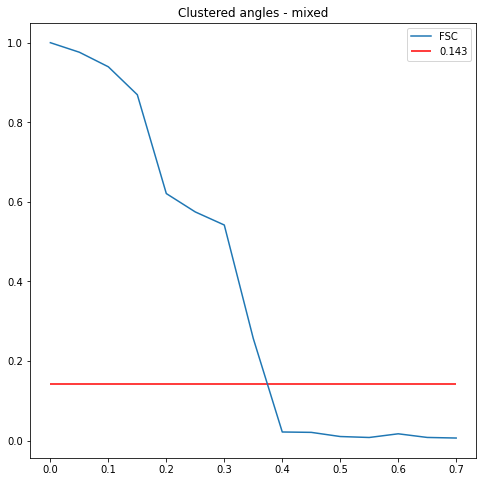

In [125]:
plt.plot(res, fsc)
plt.hlines(0.143, xmin=min(res), xmax=max(res), colors = ['r'])
plt.legend(['FSC', '0.143'])
plt.title('Clustered angles - mixed')

#### Extracting the useful points to calculate the modified FSC

In [126]:
points_v_tri = points_orientations_tri(angles_true, x_grid, y_grid, z_grid)
points_v_nn = points_orientations_nn(angles_true, x_grid, y_grid, z_grid)

In [127]:
points_v_tri.shape

(32, 32, 32)

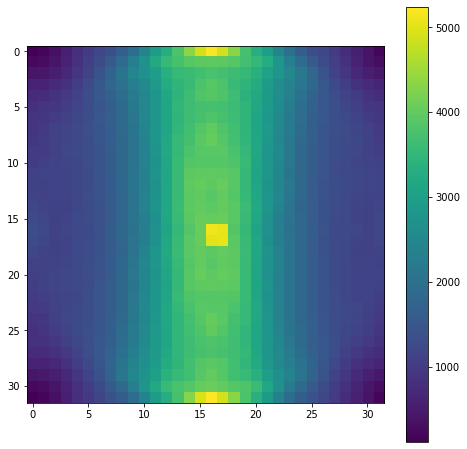

In [128]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:,:,0])); plt.colorbar()

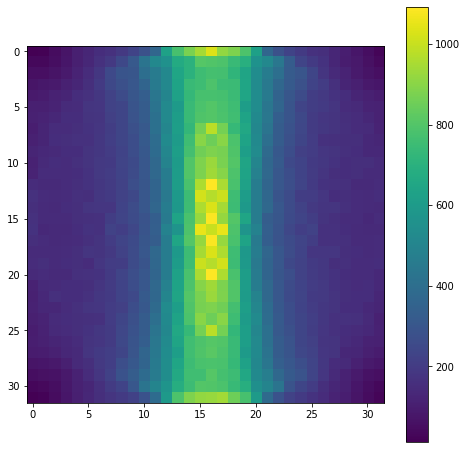

In [129]:
plt.imshow(jnp.fft.fftshift(points_v_nn[:,:,0])); plt.colorbar()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


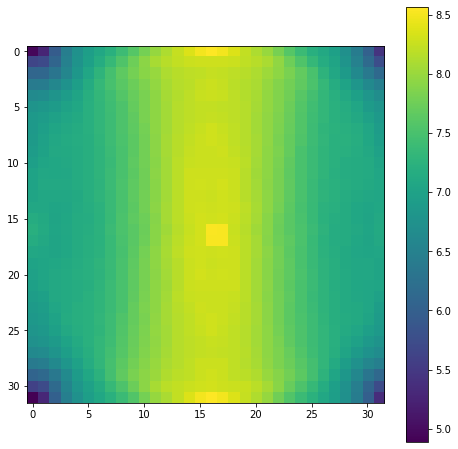

In [130]:
mip_z(np.log(np.fft.fftshift(points_v_tri)))
plt.colorbar()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


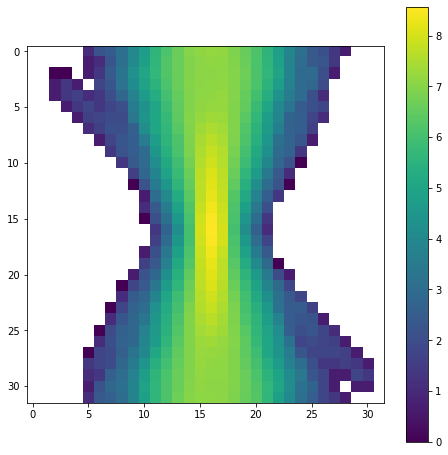

In [131]:
mip_x(np.log(np.fft.fftshift(points_v_tri)))
plt.colorbar()

### SGD

In [141]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = vol_fourier + 0.1*v * mask
alpha = 10 # this alpha works well for full 128 x 128 x 128 volume with mask
batch_size = 2
N_iter = 1000  
#N_iter = 1000 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Iter 0: mean loss = 22208.770415972802
Iter 100: mean loss = 16969.76001648917
Iter 200: mean loss = 14978.21112139295
Iter 300: mean loss = 14763.51253223055
Iter 400: mean loss = 13908.374104479237
Iter 500: mean loss = 14255.480774158194
Iter 600: mean loss = 13063.053768904865
Iter 700: mean loss = 14194.925477787747
Iter 800: mean loss = 13896.004545755652
Iter 900: mean loss = 14027.812332885125
Final loss function (over all data) =  13792.724006729517
Relative error =  0.9128653847560958


In [142]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Final loss function (over all data) =  13792.724006729517
Relative error =  0.9128653847560958


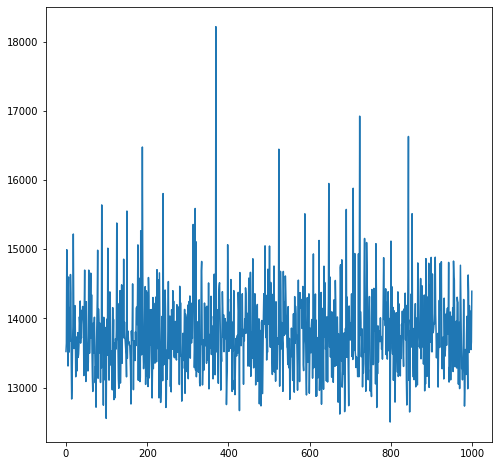

In [144]:
loss_imgs = loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)
plt.plot(loss_imgs)

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

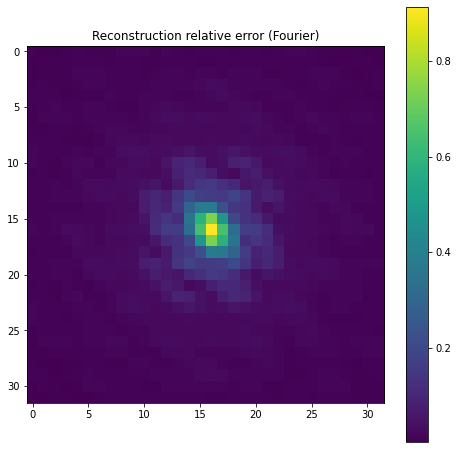

In [145]:
mip_z(jnp.abs(jnp.fft.fftshift((v-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Reconstruction MIP')

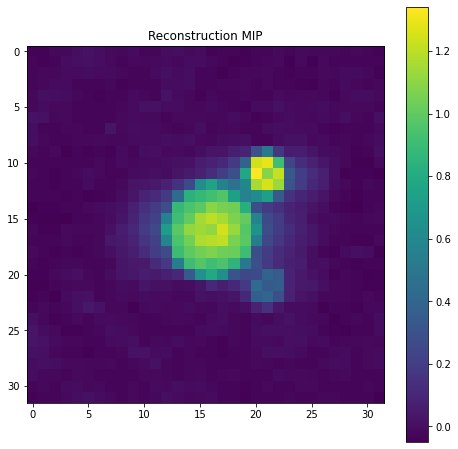

In [146]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Reconstruction MIP')

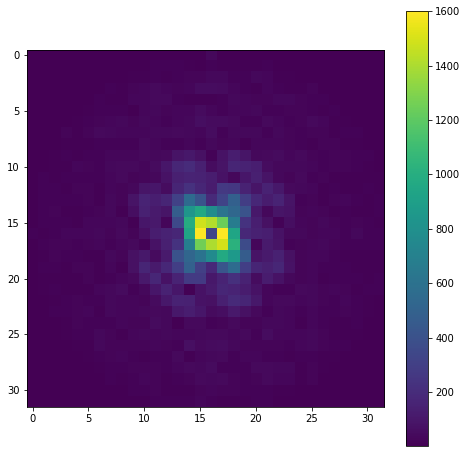

In [147]:
mip_z(jnp.abs(jnp.fft.fftshift((v)))) ; plt.colorbar()

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

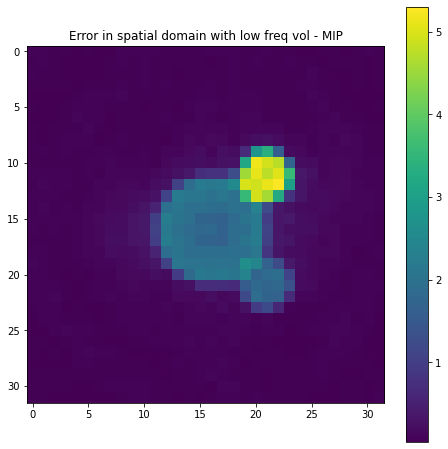

In [148]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - v*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

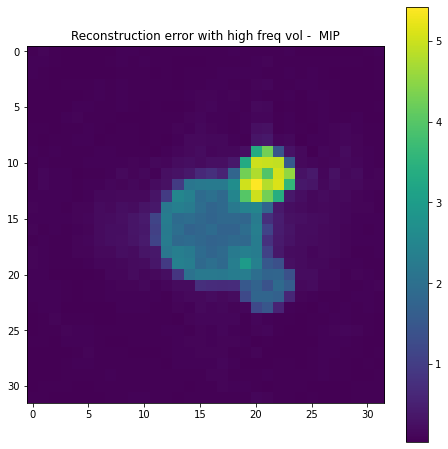

In [152]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - v)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

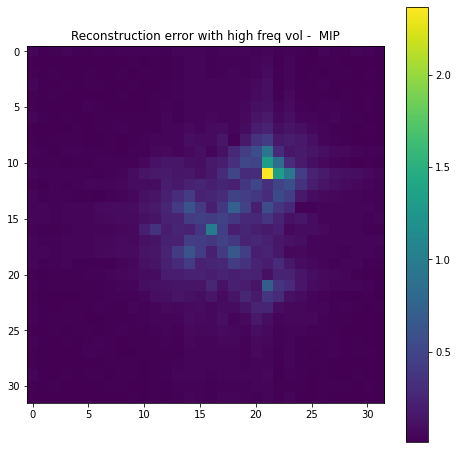

In [151]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')